# Build a deep learning model: Word Embeddings

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers                       ## conflict with -> from keras import layers

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

#from keras.models import Sequential                      ## redundant
# from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from keras import metrics


/Users/andiklausli/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andiklausli/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andiklausli/opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/andiklausli/opt/miniconda3/lib/python3.7/s

## Loading data

In [4]:
df_ham = pd.read_csv("SPAM text message 20170820 - Data.csv")
df_ham.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df_ham.shape

(5572, 2)

## Exploratory analysis

#### Discovery 
SPAMs do have patterns like: obvious words (free, winner, urgent etc.), upper-case letters and combination of these with exclamation mark, letter X, misspellings, several digits etc.

In [6]:
df_ham[:25] 

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


### Create dummy variable
Categories are replaced by integers for further processing.

In [7]:
## replace Category 
dict_trans = {'ham' : 0, 'spam': 1}
df_ham = df_ham.replace({"Category": dict_trans})

df_ham.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Fraction per category
As the dataset is inbalanced, the fractions per category are calculated to take this inbalance into account when building the model. 

In [8]:
# calculate fraction per category
grouped = df_ham.groupby('Category').count()
grouped['fraction']=grouped['Message'].div(len(df_ham))

grouped

,Message,fraction
Category,,
0,4825,0.865937
1,747,0.134063


In [9]:
# class weight
cat = grouped.index.values
frac = grouped['fraction'].values
class_weight = dict(zip(cat, frac))

### Data pre-processing
Train and test split is performed with a test size of 0.3.

In [11]:
# data pre-processing
labels = df_ham['Category'].values
messages = df_ham['Message'].values
messages_train2, messages_test2, y_train2, y_test2 = train_test_split(messages, labels, test_size=0.3, random_state=42)

In [13]:
y_train2

array([0, 0, 0, ..., 0, 0, 0])

### Word Embeddings
The word embeddings are generated using Keras' tokenizer. The aim is to integrate the semantic information into the input.

In [14]:
# Word Embeddings
from keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=5000, char_level=False)
tokenizer.fit_on_texts(messages_train2) # just on the training set...

X2_train = tokenizer.texts_to_sequences(messages_train2)
X2_test = tokenizer.texts_to_sequences(messages_test2)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1

print(X2_train[1])
print(messages_train2[1])

[19, 4, 1021, 112, 93, 6, 40, 358]
on a Tuesday night r u 4 real


In [15]:
# pad sequences
maxlen = 100

X2_train = pad_sequences(X2_train, padding='post', maxlen=maxlen)
X2_test = pad_sequences(X2_test, padding='post', maxlen=maxlen)

### Model Building

In [16]:
# building the model2 with the Embedding Layer
embedding_dim = 50 # the smaller the better for the computational performance...

model2 = keras.Sequential()
model2.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model2.add(layers.Flatten()) #if after the embedding layer a Dense layer follows, the output has to be flattened
model2.add(layers.Dense(64, activation='relu')) #same layers and parameters as in model 1
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[metrics.mae, metrics.binary_accuracy])

model2.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           375050    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                320064    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 695,179
Trainable params: 695,179
Non-trai

### Fitting the Model

In [14]:
# fitting model2
history2 = model2.fit(X2_train, y_train2,
                    epochs=100,
                    verbose=True,
                    validation_data=(X2_test, y_test2),
                    batch_size=10, class_weight=class_weight)


Train on 3900 samples, validate on 1672 samples


2021-09-10 23:15:51.041795: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-10 23:15:51.042670: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
3900/3900 [==============================] - 3s 772us/sample - loss: 0.0406 - mean_absolute_error: 0.1012 - binary_accuracy: 0.9200 - val_loss: 0.1270 - val_mean_absolute_error: 0.0770 - val_binary_accuracy: 0.9839
Epoch 2/100
3900/3900 [==============================] - 2s 603us/sample - loss: 0.0118 - mean_absolute_error: 0.0452 - binary_accuracy: 0.9892 - val_loss: 0.0669 - val_mean_absolute_error: 0.0175 - val_binary_accuracy: 0.9862
Epoch 3/100
3900/3900 [==============================] - 2s 580us/sample - loss: 0.0017 - mean_absolute_error: 0.0046 - binary_accuracy: 0.9972 - val_loss: 0.0841 - val_mean_absolute_error: 0.0160 - val_binary_accuracy: 0.9856
Epoch 4/100
3900/3900 [==============================] - 2s 550us/sample - loss: 9.0762e-04 - mean_absolute_error: 0.0021 - binary_accuracy: 0.9987 - val_loss: 0.0632 - val_mean_absolute_error: 0.0127 - val_binary_accuracy: 0.9898
Epoch 5/100
3900/3900 [==============================] - 2s 553us/sample - loss: 9.9920e

Epoch 36/100
3900/3900 [==============================] - 3s 672us/sample - loss: 1.8577e-08 - mean_absolute_error: 7.8020e-08 - binary_accuracy: 1.0000 - val_loss: 0.1077 - val_mean_absolute_error: 0.0101 - val_binary_accuracy: 0.9898
Epoch 37/100
3900/3900 [==============================] - 3s 647us/sample - loss: 1.5051e-08 - mean_absolute_error: 5.8788e-08 - binary_accuracy: 1.0000 - val_loss: 0.1099 - val_mean_absolute_error: 0.0101 - val_binary_accuracy: 0.9898
Epoch 38/100
3900/3900 [==============================] - 3s 646us/sample - loss: 1.3137e-08 - mean_absolute_error: 6.0293e-08 - binary_accuracy: 1.0000 - val_loss: 0.1092 - val_mean_absolute_error: 0.0101 - val_binary_accuracy: 0.9898
Epoch 39/100
3900/3900 [==============================] - 3s 708us/sample - loss: 1.0996e-08 - mean_absolute_error: 4.4252e-08 - binary_accuracy: 1.0000 - val_loss: 0.1107 - val_mean_absolute_error: 0.0101 - val_binary_accuracy: 0.9898
Epoch 40/100
3900/3900 [==============================] 

Epoch 71/100
3900/3900 [==============================] - 3s 703us/sample - loss: 3.9437e-10 - mean_absolute_error: 1.9627e-09 - binary_accuracy: 1.0000 - val_loss: 0.1330 - val_mean_absolute_error: 0.0101 - val_binary_accuracy: 0.9898
Epoch 72/100
3900/3900 [==============================] - 3s 762us/sample - loss: 2.8976e-10 - mean_absolute_error: 9.7675e-10 - binary_accuracy: 1.0000 - val_loss: 0.1351 - val_mean_absolute_error: 0.0101 - val_binary_accuracy: 0.9898
Epoch 73/100
3900/3900 [==============================] - 3s 738us/sample - loss: 2.7399e-10 - mean_absolute_error: 1.0651e-09 - binary_accuracy: 1.0000 - val_loss: 0.1376 - val_mean_absolute_error: 0.0102 - val_binary_accuracy: 0.9898
Epoch 74/100
3900/3900 [==============================] - 3s 723us/sample - loss: 2.3720e-10 - mean_absolute_error: 1.0760e-09 - binary_accuracy: 1.0000 - val_loss: 0.1394 - val_mean_absolute_error: 0.0103 - val_binary_accuracy: 0.9898
Epoch 75/100
3900/3900 [==============================] 

### Evaluation of Performance

In [15]:
met_train = model2.evaluate(X2_train, y_train2, verbose=False)
print("Training Accuracy: {:.4f}".format(met_train[2]))
met_test = model2.evaluate(X2_test, y_test2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(met_test[2]))

Training Accuracy: 1.0000
Testing Accuracy:  0.9898


In [19]:
print(history2.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'binary_accuracy', 'val_loss', 'val_mean_absolute_error', 'val_binary_accuracy'])


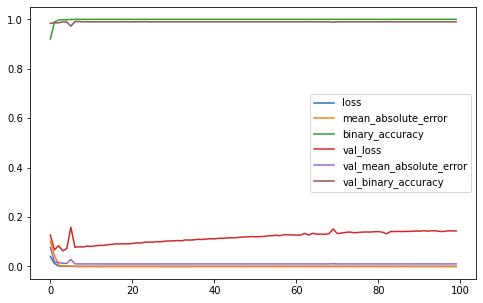

In [16]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.show()

In [18]:
from sklearn.metrics import accuracy_score
y_pred = model2.predict_classes(X2_test)

y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]], dtype=int32)

In [44]:
#!pip3 install mlxtend

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

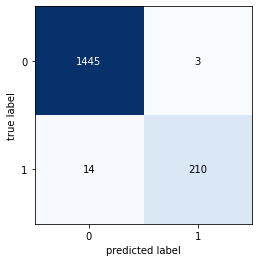

In [19]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test2, y_pred)
plot_confusion_matrix(conf_mat=mat)

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1448
           1       0.99      0.93      0.96       224

    accuracy                           0.99      1672
   macro avg       0.99      0.97      0.98      1672
weighted avg       0.99      0.99      0.99      1672



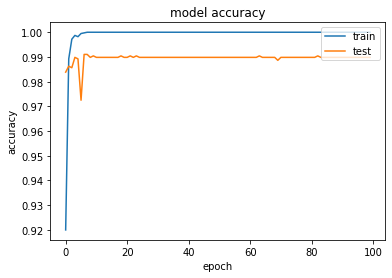

In [21]:
# accuracy vs. epoch plot
plt.plot(history2.history['binary_accuracy'])
plt.plot(history2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

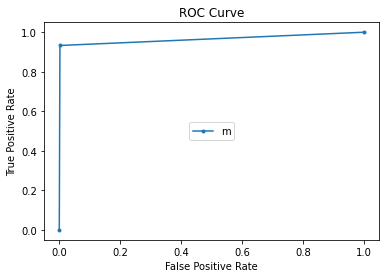

In [52]:
# ROC curve
from sklearn.metrics import roc_curve, auc

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test2, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend('model 2', loc='center')
plt.show()

## Interpretation
Accuracy is a bit higher than with the base model. However, there is no loss at training which rises the question how the model can learn. It seems as if there is a serious overfitting in the model. Accuracy and performance in general do not change significantly when 